In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt

In [2]:
# Load input data
challenge_set =pd.read_csv("challenge_set_addParq_addApt.csv")
challenge_set['month']=pd.DatetimeIndex(challenge_set['date']).month
final_submission_set =pd.read_csv("final_submission_set_addParq_addApt.csv")
final_submission_set['month']=pd.DatetimeIndex(final_submission_set['date']).month
final_submission_set.head()

,Unnamed: 0.1,Unnamed: 0,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,...,maxAlt,ades_lat,ades_lon,ades_latlon,ades_name,adep_lat,adep_lon,adep_latlon,adep_name,month
0,0,0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,...,36025.0,45.725996,5.090139,"(45.725996, 5.090139)",LYS,40.898602,29.309200,"(40.898602, 29.3092)",SAW,1
1,1,1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,...,40000.0,40.639447,-73.779317,"(40.639447, -73.779317)",JFK,50.901402,4.484440,"(50.901402, 4.48444)",BRU,1
2,2,2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,...,35000.0,51.470600,-0.461941,"(51.4706, -0.461941)",LHR,25.793200,-80.290604,"(25.79319953918457, -80.29060363769531)",MIA,1
3,3,3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,...,39000.0,38.282200,-0.558156,"(38.2822, -0.558156)",ALC,50.901402,4.484440,"(50.901402, 4.48444)",BRU,1
4,4,4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,...,31000.0,49.012798,2.550000,"(49.012798, 2.55)",CDG,47.458056,8.548056,"(47.458056, 8.548056)",ZRH,1


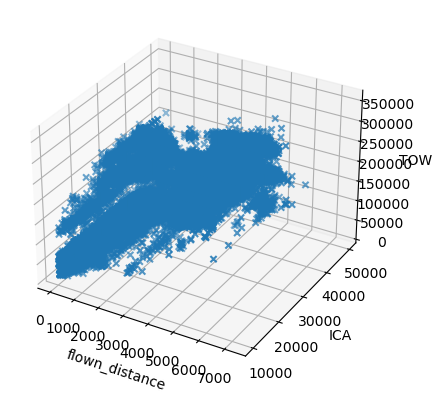

In [3]:
# Visualise input data set
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = challenge_set["flown_distance"]
ys = challenge_set["ICA"]
zs = challenge_set["tow"]
ax.scatter(xs, ys, zs, marker='x')

ax.set_xlabel('flown_distance')
ax.set_ylabel('ICA')
ax.set_zlabel('TOW')

plt.show()

# # Plot TrainData TOW vs FlownDist
# plt.scatter(challenge_set["flown_distance"],challenge_set["tow"])
# plt.grid('minor')
# plt.xlabel('flown_distance (nm)')
# plt.ylabel('TOW (kg)')
# plt.title('Train Data')
# plt.show()

In [4]:
# ---------------Version 10---------------
# Create dummy min TOW for each ACtype group for ExtraTrees.
train_group_by_ac = challenge_set[["aircraft_type", "tow"]].groupby("aircraft_type")
min_tow_by_ac = train_group_by_ac.min()
# print(min_tow_by_ac)
ac_tows = min_tow_by_ac["tow"].values
ac_list = min_tow_by_ac["tow"].index.values
type_dic = {}
for i in range(len(ac_tows)):
    type_dic[ac_list[i]] = ac_tows[i]
challenge_set["actype_mintow"] = challenge_set["aircraft_type"].map(type_dic)

train_df = challenge_set[["actype_mintow","flight_duration","flown_distance","taxiout_time","tow"]]
X = train_df[["flight_duration","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
y = train_df["tow"].to_numpy()

# ExtraTreeRegression with Train Test Split
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    # ExTreeReg_Sample = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
    # score = cross_val_score(ExTreeReg_Sample, X_test, y_test, scoring='neg_root_mean_squared_error').mean().round(2)
    # print("Train Test Split cross val score is: ",score)
# cross val score is:  -5866.8

# ExtraTreeRegression with All Train Data
ExTreeReg_All = ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_All.predict(X)
score = cross_val_score(ExTreeReg_All, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("All Train Data cross val score is: ",score)
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)
# cross val score is: -6147.41

# Pred Submission Set (v10)
final_submission_set["actype_mintow"] = final_submission_set["aircraft_type"].map(type_dic)
submi_df = final_submission_set[["actype_mintow","flight_duration","flown_distance","taxiout_time"]]
X = submi_df[["flight_duration","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
final_submission_set_pred = ExTreeReg_All.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set.to_csv("final_submission_set_ExTreeReg_All.csv")
### RMSE score on OSN Ranking = 5764.1

All Train Data cross val score is:  -5621.66


In [5]:
# ---------------Version 11---------------
# # Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 1)
group_by_acOp = challenge_set[["aircraft_type", "airline","tow"]].groupby(["aircraft_type", "airline"])
group_by_ac = challenge_set[["aircraft_type", "tow"]].groupby(["aircraft_type"])
# group_by_acOp.head(5)
mean_group_by_acOp = group_by_acOp.mean()
mean_group_by_ac = group_by_ac.mean()
# print(mean_group_by_acOp)
acOp_tows = mean_group_by_acOp["tow"].values
acOp_list = mean_group_by_acOp["tow"].index.values
ac_tows = mean_group_by_ac["tow"].values
ac_list = mean_group_by_ac["tow"].index.values
# print(acOp_list)
acOp_dic = {}
for i in range(len(acOp_list)):
    acOp_dic[acOp_list[i]] = acOp_tows[i]
ac_dic = {}
for i in range(len(ac_list)):
    ac_dic[ac_list[i]] = ac_tows[i]
challenge_set['acOp'] = challenge_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
challenge_set["acOp_meantow"] = challenge_set["acOp"].map(acOp_dic)
# print(challenge_set[["acOp","acOp_meantow"]])

# Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 2)
train_df = challenge_set[["actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with All Train Data
ExTreeReg_acOp = ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_acOp.predict(X)
score = cross_val_score(ExTreeReg_acOp, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  -5083.28
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

# ACtype/Airline group Pred Submission Set  (Step 3) (v11)
final_submission_set["actype_mintow"] = final_submission_set["aircraft_type"].map(type_dic)
# final_submission_set["actype_meantow"] = final_submission_set["aircraft_type"].map(ac_dic)
final_submission_set['acOp'] = final_submission_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
final_submission_set["acOp_meantow"] = final_submission_set["acOp"].map(acOp_dic)
# print(final_submission_set["acOp_meantow"])
# print(final_submission_set["acOp_meantow"].isna().sum())
# print(final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]])
# print(final_submission_set.loc[[28098,78003,102792], ["acOp_meantow"]])
# print(final_submission_set["actype_meantow"])
# final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]] = final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["actype_meantow"]]
final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]] = 79482.25723 # Average TOW of all training set (only 3 lines from final_submission_set is affected..)
print(final_submission_set.loc[[28098,78003,102792], ["acOp_meantow"]])
# print(final_submission_set)
submi_df = final_submission_set[["actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
final_submission_set_pred = ExTreeReg_acOp.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set.to_csv("final_submission_set_ExTreeReg_acOp.csv")
### RMSE score on OSN Ranking = 

cross val score is:  -4567.56
        acOp_meantow
28098    79482.25723
78003    79482.25723
102792   79482.25723


In [7]:
# ---------------Version 12--------------- (Section 1)
# Include ICA and maxAlt effects
# # Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 1)
group_by_acOp = challenge_set[["aircraft_type", "airline","tow"]].groupby(["aircraft_type", "airline"])
group_by_ac = challenge_set[["aircraft_type","tow","ICA","maxAlt"]].groupby(["aircraft_type"])
mean_group_by_acOp = group_by_acOp.mean()
mean_group_by_ac = group_by_ac.mean()
# print(mean_group_by_acOp)
acOp_tows = mean_group_by_acOp["tow"].values
acOp_list = mean_group_by_acOp["tow"].index.values
ac_tows = mean_group_by_ac["tow"].values
ac_ICAs = mean_group_by_ac["ICA"].values
ac_maxAlts = mean_group_by_ac["maxAlt"].values
ac_list = mean_group_by_ac["tow"].index.values
# print(acOp_list)
acOp_dic = {}
for i in range(len(acOp_list)):
    acOp_dic[acOp_list[i]] = acOp_tows[i]
ac_dic = {}
acICA_dic = {}
acmxAlt_dic = {}
for i in range(len(ac_list)):
    ac_dic[ac_list[i]] = ac_tows[i]
    acICA_dic[ac_list[i]] = ac_ICAs[i]
    acmxAlt_dic[ac_list[i]] = ac_maxAlts[i]
# print(ac_dic)
challenge_set['acOp'] = challenge_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
challenge_set["acOp_meantow"] = challenge_set["acOp"].map(acOp_dic)
challenge_set["actype_meantow"] = challenge_set["aircraft_type"].map(ac_dic)
challenge_set["actype_meanICA"] = challenge_set["aircraft_type"].map(acICA_dic)
challenge_set["actype_meanmaxAlt"] = challenge_set["aircraft_type"].map(acmxAlt_dic)
# print(challenge_set[["acOp","acOp_meantow"]])

print(challenge_set["ICA"].isna().sum(), "rows of NaN from challenge_set is filled with ICA=35000")
challenge_set.loc[challenge_set["ICA"].isna(), ["ICA"]] = 35000
print(challenge_set["maxAlt"].isna().sum(), "rows of NaN from challenge_set is filled with maxAlt=38000")
challenge_set.loc[challenge_set["maxAlt"].isna(), ["maxAlt"]] = 38000
# challenge_set.loc[challenge_set["ICA"].isna(), ["ICA"]].replace(challenge_set.loc[challenge_set["ICA"].isna(), ["actype_meanICA"]])
# challenge_set.loc[challenge_set["maxAlt"].isna(), ["maxAlt"]] = challenge_set.loc[challenge_set["maxAlt"].isna(), ["actype_meanmaxAlt"]]
# print(challenge_set.loc[challenge_set["maxAlt"].isna(), ["ICA", "maxAlt", "actype_meanICA", "actype_meanmaxAlt"]])

911 rows of NaN from challenge_set is filled with ICA=35000
911 rows of NaN from challenge_set is filled with maxAlt=38000


In [8]:
# ---------------Version 12 (section 2) ---------------
# Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 2)
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 7 Parameters: "actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt"
ExTreeReg_7Param = ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_7Param.predict(X)
score = cross_val_score(ExTreeReg_7Param, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  -4095.77
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

# ACtype/Airline group Pred Submission Set  (Step 3) (v11)
# final_submission_set["actype_mintow"] = final_submission_set["aircraft_type"].map(type_dic)
final_submission_set["actype_meantow"] = final_submission_set["aircraft_type"].map(ac_dic)
final_submission_set['acOp'] = final_submission_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
final_submission_set["acOp_meantow"] = final_submission_set["acOp"].map(acOp_dic)

# final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]] = 79482.25723 # Average TOW of all training set (only 3 lines from final_submission_set is affected..)
# final_submission_set.loc[final_submission_set["ICA"].isna(), ["ICA"]] = 35000
# final_submission_set.loc[final_submission_set["maxAlt"].isna(), ["maxAlt"]] = 38000

print(final_submission_set["acOp_meantow"].isna().sum(), "rows of NaN from final submission set is filled with acOp_meantow=79482.25723")
final_submission_set["acOp_meantow"]=final_submission_set["acOp_meantow"].fillna(79482.25723)
print(final_submission_set["ICA"].isna().sum(), "rows of NaN from final submission set is filled with ICA=35000")
final_submission_set["ICA"]=final_submission_set["ICA"].fillna(35000)
print(final_submission_set["maxAlt"].isna().sum(), "rows of NaN from final submission set is filled with maxAlt=38000")
final_submission_set["maxAlt"]=final_submission_set["maxAlt"].fillna(38000)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt"]].to_numpy()
final_submission_set_pred = ExTreeReg_7Param.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_7Param.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3883.25
3 rows of NaN from final submission set is filled with acOp_meantow=79482.25723
379 rows of NaN from final submission set is filled with ICA=35000
379 rows of NaN from final submission set is filled with maxAlt=38000


In [9]:
# ---------------Version 14 (Section 3 - Run Version 12 Section 1 and 2 First) ---------------
# characterise destination airport by the residuals from previous best training.
tow_by_des = challenge_set[["ades","tow_diff"]].groupby("ades")
mean_group_by_des = tow_by_des.mean()
des_dev = mean_group_by_des["tow_diff"].values
des_list = mean_group_by_des["tow_diff"].index.values
des_dic = {}
for i in range(len(des_dev)):
    des_dic[des_list[i]] = des_dev[i]
challenge_set["des_dev"] = challenge_set["adep"].map(des_dic)
print(challenge_set["des_dev"].isna().sum(), "rows of NaN from challenge_set is filled with des_dev=0")
challenge_set["des_dev"] = challenge_set["des_dev"].fillna(0)
final_submission_set["des_dev"] = final_submission_set["adep"].map(des_dic)
print(final_submission_set["des_dev"].isna().sum(), "rows of NaN from final submission set is filled with des_dev=0")
final_submission_set["des_dev"]=final_submission_set["des_dev"].fillna(0)

1337 rows of NaN from challenge_set is filled with des_dev=0
594 rows of NaN from final submission set is filled with des_dev=0


In [10]:
# ---------------Version 14 (section 4) ---------------
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 8 Parameters: "actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev"
ExTreeReg_ades = ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_ades.predict(X)
score = cross_val_score(ExTreeReg_ades, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  -4028.31
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev"]].to_numpy()
final_submission_set_pred = ExTreeReg_ades.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_ades.csv",index=False)
### RMSE score on OSN Ranking = 3801.73

cross val score is:  -3812.79


In [12]:
# ---------------Version 15 (section 4 - Run Version 12 and 14 Section 1 to 3 First) ---------------
print(challenge_set["ades_lon"].isna().sum(), "rows of NaN from challenge_set is filled with ades_lon=0")
challenge_set.loc[challenge_set["ades_lon"].isna(), ["ades_lon"]] = 0
print(challenge_set["ades_lat"].isna().sum(), "rows of NaN from challenge_set is filled with ades_lat=0")
challenge_set.loc[challenge_set["ades_lat"].isna(), ["ades_lat"]] = 0
print(challenge_set["adep_lon"].isna().sum(), "rows of NaN from challenge_set is filled with adep_lon=0")
challenge_set.loc[challenge_set["adep_lon"].isna(), ["adep_lon"]] = 0
print(challenge_set["adep_lat"].isna().sum(), "rows of NaN from challenge_set is filled with adep_lat=0")
challenge_set.loc[challenge_set["adep_lat"].isna(), ["adep_lat"]] = 0

print(final_submission_set["ades_lon"].isna().sum(), "rows of NaN from final_submission_set is filled with ades_lon=0")
final_submission_set.loc[final_submission_set["ades_lon"].isna(), ["ades_lon"]] = 0
print(final_submission_set["ades_lat"].isna().sum(), "rows of NaN from final_submission_set is filled with ades_lat=0")
final_submission_set.loc[final_submission_set["ades_lat"].isna(), ["ades_lat"]] = 0
print(final_submission_set["adep_lon"].isna().sum(), "rows of NaN from final_submission_set is filled with adep_lon=0")
final_submission_set.loc[final_submission_set["adep_lon"].isna(), ["adep_lon"]] = 0
print(final_submission_set["adep_lat"].isna().sum(), "rows of NaN from final_submission_set is filled with adep_lat=0")
final_submission_set.loc[final_submission_set["adep_lat"].isna(), ["adep_lat"]] = 0

12 rows of NaN from challenge_set is filled with ades_lon=0
12 rows of NaN from challenge_set is filled with ades_lat=0
97 rows of NaN from challenge_set is filled with adep_lon=0
97 rows of NaN from challenge_set is filled with adep_lat=0
9 rows of NaN from final_submission_set is filled with ades_lon=0
9 rows of NaN from final_submission_set is filled with ades_lat=0
39 rows of NaN from final_submission_set is filled with adep_lon=0
39 rows of NaN from final_submission_set is filled with adep_lat=0


In [15]:
# ---------------Version 15 (section 5) ---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v15.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3689.01


In [20]:
# --------------------Version 27 Gradient Boosting Trial---------------------
from sklearn.ensemble import GradientBoostingRegressor
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
GBReg = GradientBoostingRegressor( n_estimators=500, max_depth=4, min_samples_split=5,learning_rate=0.01,loss="squared_error").fit(X, y)
training_set_pred = GBReg.predict(X)
score = cross_val_score(GBReg, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = GBReg.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_GradientBoosting_v27.csv",index=False)

cross val score is:  -4604.48


In [19]:
# --------------------Version 27.1 Gradient Boosting Trial---------------------
from sklearn.ensemble import GradientBoostingRegressor
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
GBReg = GradientBoostingRegressor( n_estimators=500, max_depth=16, min_samples_split=8,learning_rate=0.01,loss="squared_error").fit(X, y)
training_set_pred = GBReg.predict(X)
score = cross_val_score(GBReg, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = GBReg.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_GradientBoosting_v27.1.csv",index=False)

cross val score is:  -3880.23


In [22]:
# ---------------Version 26 (section 5) (v15+bootstrap+max samples+500 estimators) recreation---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=500, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v15.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3674.47


In [26]:
# ---------------Version 26.1 (section 5) (v15+bootstrap+max samples+500 estimators, drop flight duration)---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v261 = ExtraTreesRegressor(n_estimators=500, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v261.predict(X)
score = cross_val_score(ExTreeReg_v261, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v261.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v261.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3685.15


In [27]:
# ---------------Version 26.2 (section 5) (v15+bootstrap+max samples+500 estimators drop flight duration and taxi out time)---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["acOp_meantow","flown_distance","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v262 = ExtraTreesRegressor(n_estimators=500, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v262.predict(X)
score = cross_val_score(ExTreeReg_v262, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["acOp_meantow","flown_distance","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v262.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v262.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3686.88


In [29]:
# ---------------Version 26.3 (section 5) (v15+bootstrap+max samples+400 estimators drop flight duration and taxi out time)---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["acOp_meantow","flown_distance","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v262 = ExtraTreesRegressor(n_estimators=400, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v262.predict(X)
score = cross_val_score(ExTreeReg_v262, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["acOp_meantow","flown_distance","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v262.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v263.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3689.07


In [33]:
# ---------------Version 26.4 (section 5) (v15+bootstrap+max samples+450 estimators drop flight duration and taxi out time and desdev)---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["acOp_meantow","flown_distance","actype_meantow","ICA","maxAlt","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v262 = ExtraTreesRegressor(n_estimators=450, random_state=20241026, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v262.predict(X)
score = cross_val_score(ExTreeReg_v262, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["acOp_meantow","flown_distance","actype_meantow","ICA","maxAlt","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v262.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v264.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3693.21


In [42]:
# ---------------Version 26.5 (section 5) (v15+bootstrap+max samples+1000 estimators drop flight duration and taxi out time and desdev and actype_meantow)---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["acOp_meantow","flown_distance","ICA","maxAlt","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v262 = ExtraTreesRegressor(n_estimators=1000, random_state=20241026, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v262.predict(X)
score = cross_val_score(ExTreeReg_v262, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["acOp_meantow","flown_distance","ICA","maxAlt","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v262.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v265.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3694.01


In [41]:
# ---------------Version 266 (section 5) (v15+bootstrap+max samples0.2+1000 estimators) recreation---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=1000, random_state=0, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v266.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3671.86


In [40]:
# ---------------Version 267 (section 5) (v15+bootstrap+max samples 0.25+2048 estimators) recreation---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=2048, random_state=20241026, bootstrap=True, n_jobs=-1, max_samples=0.25).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v267.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3670.78


In [16]:
# ---------------Version 268 (section 5) (v15+bootstrap+max samples 0.5+2048 estimators) recreation---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=4096, random_state=20241026, bootstrap=True, n_jobs=-1, max_samples=0.17).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v268.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3675.85


In [17]:
# ---------------Version 268 (section 5) (v15+bootstrap+max samples 0.5+2048 estimators, drop desdev) recreation---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","month","ades_lon","ades_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=512, random_state=20241026, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","month","ades_lon","ades_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v2689.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3726.47


In [18]:
# ---------------Version 2691 (section 5) (v15+bootstrap+max samples 0.5+2048 estimators, drop desdev and dep) recreation---------------
# just putting everything in, 13params
train_df = challenge_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","ades_lon","ades_lat"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 13 Parameters: "flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"
ExTreeReg_v15 = ExtraTreesRegressor(n_estimators=512, random_state=20241026, bootstrap=True, n_jobs=-1, max_samples=0.2).fit(X, y)
training_set_pred = ExTreeReg_v15.predict(X)
score = cross_val_score(ExTreeReg_v15, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff_withADES"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

submi_df = final_submission_set[["actype_meantow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt","des_dev","month","ades_lon","ades_lat","adep_lon","adep_lat"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_meantow","ICA","maxAlt","ades_lon","ades_lat"]].to_numpy()
final_submission_set_pred = ExTreeReg_v15.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_v2691.csv",index=False)
### RMSE score on OSN Ranking = 

cross val score is:  -3762.93
